In [22]:
import networkx as nx 
import y0
from y0.graph import NxMixedGraph
from y0.algorithm.estimation.linear_scm import get_single_door
from y0.simulation import get_fits_df, simulate, LinearSCM, example_generators, example_graph
from y0.dsl import V1, V2, V3, V4, V5, V6, Variable
from functools import partial
import pandas as pd
import sympy as sy
from nocap import scm
import numpy as np
from numpy.random import normal, uniform
import pgmpy
#!pip install pgmpy

from statistics import fmean

import sympy
from sklearn.linear_model import LinearRegression


actual edge weights: {(V1, V2): 0.3745401188473625, (V1, V4): 0.9507143064099162, (V2, V5): 0.7319939418114051, (V4, V5): 0.5986584841970366, (V4, V6): 0.15601864044243652, (V5, V6): 0.15599452033620265, (V3, V5): 0.05808361216819946}


,V1,V3,V2,V4,V5,V6
0,0.732352,0.202230,0.690440,-0.262573,1.299773,0.826676
1,-0.575322,-0.636350,-0.848672,-0.938482,-1.170502,-0.465123
2,-0.417542,0.223706,-0.877398,-0.812674,-1.383047,-0.430400
3,0.570352,-0.600652,0.242089,0.727071,-0.329513,0.277124
4,-0.658952,-0.869897,0.650967,0.304789,1.225237,-0.152089


estimated edge weights: {(V1, V2): 0.37824213041752636, (V1, V4): 0.9552183862001729, (V2, V5): 0.731226167699574, (V4, V5): 0.5961501006131199, (V4, V6): 0.1552518605586741, (V5, V6): 0.15351805324974302, (V3, V5): 0.05827255711736592}


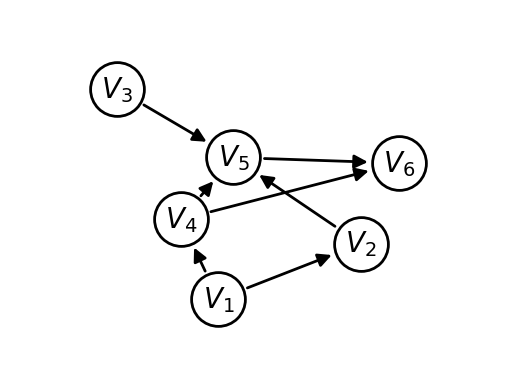

In [33]:
def get_single_door_updated(
    graph: NxMixedGraph, data: pd.DataFrame
) -> dict[tuple[Variable, Variable], float]:
    """Estimate parameter values for a linear SCM using backdoor adjustment."""
    rv = {}
    
    for source, target in graph.directed.edges():
        temp_graph = graph.copy()
        temp_graph.directed.remove_edge(source, target) # remove edge from source to target
        #pgmpy_graph = temp_graph.to_pgmpy_bayesian_network()
        pgmpy_graph = to_pgmpy_bayesian_network_updated(temp_graph)
        try:
            raw_adjustment_sets = pgmpy_graph.minimal_dseparator(source.name, target.name)
            if raw_adjustment_sets is None:
                # There are no valid adjustment sets.
                continue
            # Ensure we have a set of frozensets, with each frozenset containing variable names
            adjustment_sets = {frozenset([adjustment_set]) if isinstance(adjustment_set, str) else frozenset(adjustment_set) for adjustment_set in raw_adjustment_sets}
        except ValueError:
            # There are no valid adjustment sets.
            continue
        if not adjustment_sets:
            # There is a valid adjustment set, and it is the empty set, so just regress the target on the source.
            adjustment_sets = frozenset([frozenset([])])
        coefficients = []
        for adjustment_set in adjustment_sets:
            # Ensure adjustment_set is a set before performing the union operation.
            variables = sorted(set(adjustment_set) | {source.name})
            idx = variables.index(source.name)
            model = LinearRegression()
            model.fit(data[variables], data[target.name])
            coefficients.append(model.coef_[idx])
        rv[source, target] = fmean(coefficients)
    return rv


def to_pgmpy_bayesian_network_updated(graph:NxMixedGraph) -> pgmpy.models.BayesianNetwork:
    """Convert a mixed graph to an equivalent :class:`pgmpy.BayesianNetwork`."""
    from pgmpy.models import BayesianNetwork

    # Get all directed edges with node names
    edges = [(u.name, v.name) for u, v in graph.directed.edges()]
    
    # Initialize set for latent variables
    latents = set()
    
    # Handle undirected edges by introducing latent variables
    for u, v in graph.undirected.edges():
        latent = f"U_{u.name}_{v.name}"
        latents.add(latent)
        edges.append((latent, u.name))
        edges.append((latent, v.name))
    
    # Initialize the BayesianNetwork with edges
    model = BayesianNetwork(ebunch=edges, latents=latents)
    
    # Add all original nodes to the BayesianNetwork
    for node in graph.directed.nodes():
        if node.name not in model.nodes():
            model.add_node(node.name)
    
    return model



np.random.seed(42)

# create model
graph = example_graph # NxMixedGraph

graph.draw(prog="neato")

node_generators = {node: partial(uniform, low=-1.0, high=1.0) for node in graph.nodes()}

edge_weights = {edge: uniform(low=0.0, high=1.0) for edge in graph.directed.edges()}
print(f"actual edge weights: {edge_weights}")


# simulate data
df, fits = simulate(graph=graph, trials=100000, generators=node_generators, weights=edge_weights)
display(df.head())

# calibrate model (edge weights) to data 
estimated_edge_weights = get_single_door_updated(graph,df)
print(f"estimated edge weights: {estimated_edge_weights}")

for edge, weight in edge_weights.items():
        estimated_weight = estimated_edge_weights[edge]
        # Use numpy.allclose to compare the weights with a tolerance
        assert np.allclose(weight, estimated_weight, atol=1e-2), f"Edge {edge}: expected {weight}, got {estimated_weight}"




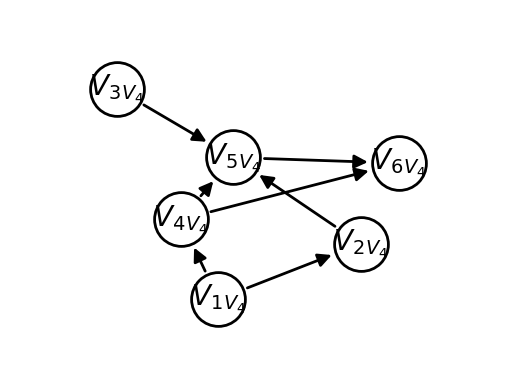

In [28]:
treatment_graph = graph.intervene(variables={V4})
treatment_graph.draw(prog="neato")

In [34]:
def remove_incoming_edge_weights(edges_dict, target_node):
    """Return a new dictionary with weights of incoming edges to the target node set to 0."""
    # Create a new dictionary to avoid modifying the original
    new_edges_dict = edges_dict.copy()
    
    # Iterate over the edges and update the weight if it's an incoming edge to the target node
    for edge, weight in edges_dict.items():
        if edge[1] == target_node:
            new_edges_dict[edge] = 0
    
    return new_edges_dict

intervention_target = V4
intervened_edge_weights = remove_incoming_edge_weights(edge_weights, intervention_target)
print(f"intervened_edge_weights: {intervened_edge_weights}")

intervened_df, intervened_fits = simulate(graph=graph, trials=10000, generators=node_generators, weights=intervened_edge_weights)
print(intervened_df.head())



intervened_edge_weights: {(V1, V2): 0.3745401188473625, (V1, V4): 0, (V2, V5): 0.7319939418114051, (V4, V5): 0.5986584841970366, (V4, V6): 0.15601864044243652, (V5, V6): 0.15599452033620265, (V3, V5): 0.05808361216819946}
         V1        V3        V2        V4        V5        V6
0 -0.296121  0.867577  0.328011  0.324733  1.024278  0.333006
1 -0.585925 -0.559909  0.475651 -0.513649 -0.340926 -1.130630
2 -0.568080  0.000271 -0.798710 -0.645409 -0.759740 -0.226583
3  0.739334  0.890955 -0.411569  0.920228  0.620526 -0.307501
4 -0.072252 -0.014158 -0.391429  0.385206 -0.598086  0.548734


In [30]:
def compute_average_treatment_effect(treatment1:pd.DataFrame, treatment2:pd.DataFrame, outcome_variables:list[Variable])->dict[Variable,float]:
    "Computes the average treatment effect (i.e., E[Y1-Y0])."

    avg_treatment_effect_dict = {}
    for v in outcome_variables:
        avg_untreated = treatment1.loc[:, str(v)].mean()
        avg_treated = treatment2.loc[:, str(v)].mean()
        avg_treatment_effect = avg_treated - avg_untreated
        avg_treatment_effect_dict[v] = avg_treatment_effect
    return avg_treatment_effect_dict


avg_treatment_effect_dict = compute_average_treatment_effect(df, intervened_df, [V1, V2, V3, V4, V5, V6])
print(f'ATE - intervening on {intervention_target}: {avg_treatment_effect_dict}')

ATE - intervening on V4: {V1: -0.006957483205771406, V2: -0.0055909905959155935, V3: 0.0021169172535607057, V4: -0.004001050727930042, V5: -0.00784432168022986, V6: 0.0021367288144334604}


In [ ]:
def intervene_on_state_variable(model:NxMixedGraph, intervention:dict[y0.dsl.Variable,float])->NxMixedGraph:
    pass

def intervene_on_parameter(model:NxMixedGraph, intervention:dict[sy.Symbol,float])->NxMixedGraph:
    pass




In [ ]:
def sample_model(model:NxMixedGraph, n_samples:int, parameters:dict[sy.Symbol,float], parameter_interventions, state_interventions)->pd.DataFrame:
    pass